# Geolithe classification

This notebooks aims at building a generalized model for Geolithe cliff datasets. It deals with 3D point cloud segmentation thanks to a supervised learning algorithm.

Contrary to the works done in a previous notebook (http://localhost:8888/notebooks/examples/pombourg-classification.ipynb), one won't train a model on a specific dataset to apply it on the same point cloud thereafter.

Here we will implement a generic algorithm, by training it on various samples.

One will use the following datasets, with associated samples:

| dataset      | vegetation | cliff | scree | road | concrete | ground |
|--------------|------------|-------|-------|------|----------|--------|
| Beausoleil_1 | x | x |  |  | x |  |
| Beausoleil_2 | x | x |  |  | x |  |
| castillon    | x | x |  |  |  |  |
| Chambon      | x | x |  | x |  |  |
| escale       | x | x |  | x |  |  |
| kansera      | x | x | x |  |  |  |
| Malaussene   | x | x | x |  |  |  |
| Pombourg     | x | x | x |  |  |  |
| Reyvroz      | x |  |  |  |  | x |
| Tancarville  | x | x | x |  |  |  |


The execution of this notebook needs that every single sample has been featurized:
```sh
geo3d index -i <dataset>.las -t 100
geo3d featurize -i <dataset>_<class>.las -c r g b -n 20 100 500 1500 -t 100 --label-scene
```
The full datasets must themselves be featurized:
```sh
geo3d index -i <dataset>.las -t 500
geo3d featurize -i <dataset>.las -c r g b -n 20 100 500 1500 -t 500
```

For the rest of the notebook, one will consider four different neighborhood sizes: 20, 200, 1000 and 2000 neighbors. For an insight of the importance of this parameter, please consider the following notebooks:
- http://localhost:8888/notebooks/examples/features-study/escale-features-study.ipynb
- http://localhost:8888/notebooks/examples/pombourg-classification.ipynb

## Introduction

### Dependency management

In [1]:
from pathlib import Path

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [4]:
from geo3dfeatures import classification, io
from geo3dfeatures.tools import train, predict, GLOSSARY

### Global variable definition

In [5]:
DATADIR = Path("..", "data")
INPUT_DIR = DATADIR / "input"
OUTPUT_DIR = DATADIR / "output"

As said in the notebook presentation, one will work with 4 different neighborhood sizes:

In [6]:
NEIGHBORHOOD_SIZES = (20, 200, 1000, 2000)

The dataset names are stored in a dedicated variable:

In [7]:
EXPERIMENTS = ("Beausoleil_1", "Beausoleil_2", "castillon", "Chambon", "escale", "kansera", "Malaussene", "Pombourg", "Reyvroz", "Tancarville")

Then one considers the Geolithe labels, as defined in the `predict` module:

In [8]:
GLOSSARY

{'vegetation': {'id': 0,
  'color': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)},
 'falaise': {'id': 1,
  'color': (0.5803921568627451, 0.5803921568627451, 0.5803921568627451)},
 'eboulis': {'id': 2,
  'color': (0.792156862745098, 0.5686274509803921, 0.3803921568627451)},
 'route': {'id': 3,
  'color': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745)},
 'beton': {'id': 4,
  'color': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549)},
 'sol': {'id': 5, 'color': (0.9254901960784314, 0.8823529411764706, 0.2)}}

dict_keys(['vegetation', 'falaise', 'eboulis', 'route', 'beton', 'sol'])


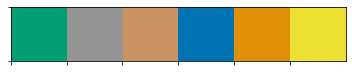

In [9]:
print(GLOSSARY.keys())
sns.palplot([g["color"] for _, g in GLOSSARY.items()])

## Data loading

One considers all the point clouds that refer to identified experiments, and build a big dataframe that contains the feature values for known points, in order to build a training dataset.

In [10]:
dfs = []
for experiment in EXPERIMENTS:
    dfs.append(train.create_training_dataset(DATADIR, experiment, NEIGHBORHOOD_SIZES, GLOSSARY))
bigdf = pd.concat(dfs, axis=0)
del dfs

[17:18:43] io.load_features (INFO) - Recover features stored in ../data/output/Beausoleil_1/features/features_vegetation.h5
[17:18:44] utils._init_num_threads (INFO) - NumExpr defaulting to 4 threads.
[17:18:45] io.load_features (INFO) - Recover features stored in ../data/output/Beausoleil_1/features/features_falaise.h5
[17:18:49] io.load_features (WARNING) - File ../data/output/Beausoleil_1/features/features_eboulis.h5 does not exist, verify the 'sample' argument!
[17:18:49] io.load_features (WARNING) - File ../data/output/Beausoleil_1/features/features_route.h5 does not exist, verify the 'sample' argument!
[17:18:49] io.load_features (INFO) - Recover features stored in ../data/output/Beausoleil_1/features/features_beton.h5
[17:18:57] io.load_features (WARNING) - File ../data/output/Beausoleil_1/features/features_sol.h5 does not exist, verify the 'sample' argument!
[17:18:58] io.load_features (INFO) - Recover features stored in ../data/output/Beausoleil_2/features/features_vegetation.

At this point, we get a dataset of around 2.5 millions of annotated points, with 79 features (19 features over 4 different neighborhood sizes, plus RGB channels) and a column of labels.

In [11]:
bigdf.shape

(2512089, 80)

This dataset contains a large part of vegetation points (around the half of annotated points) and cliff points (~35% of annotated points). Road, scree, ground and concrete points are far less represented.

In [12]:
bigdf.label.value_counts()

0    1281457
1     865199
4     155396
2     103350
5      70607
3      36080
Name: label, dtype: int64

We basically split this dataset by putting 75% of points in a training set, and the remaining 25% in a testing set.

In [13]:
train_dataset, test_dataset = train_test_split(bigdf, test_size=0.25, shuffle=True)

In [14]:
X_train = train_dataset.drop(columns=["label"])
Y_train = train_dataset["label"]
X_test = test_dataset.drop(columns=["label"])
Y_test = test_dataset["label"]

In [15]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1884066, 79), (1884066,), (628023, 79), (628023,))

At this stage of the notebook, one then has ~1.9M points in the training set, and ~0.6M points in the testing set.

## Semantic segmentation model training

One considers a pipeline that associates a min-max-normalization function and a logistic regression, as defined in the `classification` module. This model is trained with the previous training set of 1.9M annotated points.

In [16]:
clf = classification.train_predictive_model(X_train, Y_train)

[17:29:19] warnings._showwarnmsg (WARNING) - /home/rde/.virtualenvs/univers/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



The model can be evaluated regarding the testing set (0.6M points, that are still unknown for the model).

In [17]:
clf.score(X_test, Y_test)

0.9723895462427331

Moreover one can evaluate the model accuracy by comparing the ground-truth and predicted labels.

First testing set labels are guessed by the model:

In [18]:
Y_pred = clf.predict(X_test)

Then a confusion matrix that represents our model performance can be drawn. As an example, amongst all the true vegetation points, 311948 are recognized, 7006 are classified as cliff, 934 as scree, 589 as ground, etc.

In [19]:
conf_matrix = confusion_matrix(Y_test, Y_pred)
conf_matrix

array([[311922,   7131,   1005,      0,      0,    714],
       [  5048, 210532,    338,      0,    405,      7],
       [   156,   1456,  24154,     24,      0,      0],
       [     0,      0,      9,   9098,      0,      0],
       [     0,    377,      0,      0,  38178,      0],
       [   670,      0,      0,      0,      0,  16799]])

For a sake of readability, one can draw a heatmap with accuracy percentage from this matrix:

In [20]:
conf_matrix = 100. * conf_matrix / np.sum(conf_matrix, axis=1)

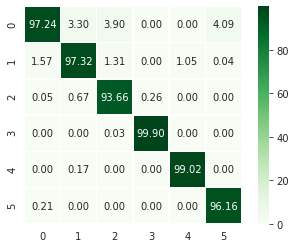

In [21]:
with sns.axes_style("white", {"xtick.major.size": 12.0, "ylim": -0.5}):
    ax = sns.heatmap(conf_matrix, linewidth=0.5, annot=True, square=True, fmt=".2f", cmap="Greens")
    ax.set_ylim((6, 0))  # Set it manually as there is a matplotlib regression (for more details: https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot)
    

As a result, one can see that the model seems quite robust, with only a few prediction errors. Only 90.6% of vegetation points are well-classified, whilst 95.9% of cliff points are recognized. Other labels present a really high accuracy score (>99%).

As this notebook implies the computation of big data structures, one clean up the session to avoid useless memory consumption.

In [22]:
del bigdf, train_dataset, test_dataset, X_train, Y_train, X_test, Y_test, Y_pred

## Label prediction

In the following cells of the notebook, one prepares some results. The prediction model will be used to infer point labels in available point clouds.

One needs to define a function to automate the process:

In [23]:
def predict_label_for_experiment(experiment, classifier, datadir, neighborhoods, glossary):
    """Predict label and return corresponding colored version of each point in a dataframe
    
    Parameters
    ----------
    experiment : str
        Name of the dataset
    classifier : sklearn.pipeline
        Prediction model
    datadir : str
        Path of the data on the file system
    neighborhoods : list of ints
        Set of neighborhood sizes
    glossary : dict
        Dataset labels
    Returns
    -------
    pd.DataFrame
        Output data with colored labels
    """
    df = io.load_features(datadir, experiment, neighborhoods)
    points = df[list("xyz")].copy()
    df.drop(columns=list("xyz"), inplace=True)
    Y_pred = classifier.predict(df)
    print(pd.Series([[key for key, value in glossary.items() if value["id"] == y] for y in Y_pred]).value_counts())
    output = classification.colorize_labels(points, Y_pred, GLOSSARY)
    return output

As an additional pre-requisite, and as notified in the notebook introduction, one must compute the features associated to each point with the following commands:
```bash
geo3d index -i <dataset>.las -t 500
geo3d featurize -i <dataset>.las -c r g b -n 20 200 1000 2000 -t 500
```

One will only focus on small point clouds (less than 3M points). For further analysis, interested readers may look at the CLI documentation for running their own analysis!

### Beausoleil_2

The first dataset of interest is `Beausoleil_2`. It is composed of vegetation, cliff and concrete.

<img src="../docs/images/Beausoleil2.png" width="400px"></img>

In [24]:
Beausoleil2_df = predict_label_for_experiment(EXPERIMENTS[1], clf, DATADIR, NEIGHBORHOOD_SIZES, GLOSSARY)

[17:29:27] io.load_features (INFO) - Recover features stored in ../data/output/Beausoleil_2/features/features.h5


[falaise]       597209
[vegetation]    363562
[beton]          74368
[eboulis]          532
[sol]                1
dtype: int64


One then saves the prediction output onto the file system, by specifying the configuration (logistic regression algorithm, and full set of features).

In [25]:
classification.save_labels(Beausoleil2_df, DATADIR, EXPERIMENTS[1], NEIGHBORHOOD_SIZES, None, "logreg", None, "full")

[17:30:40] classification.save_labels (INFO) - Predicted labels saved into ../data/output/Beausoleil_2/prediction/logreg-20-200-1000-2000-full.las


The memory is freed again.

In [26]:
del Beausoleil2_df

...And here comes the result! Quite interesting, isn't it: the algorithm finds the concrete zone, and almost all the vegetation area, even if some predicted vegetation points are more "border" points, identified as vegetation because of a computation artefact.

<img src="../docs/images/Beausoleil2_logreg-20-200-1000-2000.png" width="400px"></img>

### Chambon

Then comes the `Chambon` dataset, a dark cliff scattered with vegetation, that overhangs a road.

<img src="../docs/images/Chambon.png" width="300px"></img>

In [27]:
chambon_df = predict_label_for_experiment(EXPERIMENTS[3], clf, DATADIR, NEIGHBORHOOD_SIZES, GLOSSARY)

[17:30:41] io.load_features (INFO) - Recover features stored in ../data/output/Chambon/features/features.h5


[falaise]       1036148
[vegetation]     811378
[route]          488818
[eboulis]         94323
[beton]           11551
dtype: int64


In [28]:
classification.save_labels(chambon_df, DATADIR, EXPERIMENTS[3], NEIGHBORHOOD_SIZES, None, "logreg", None, "full")

[17:34:16] classification.save_labels (INFO) - Predicted labels saved into ../data/output/Chambon/prediction/logreg-20-200-1000-2000-full.las


In [29]:
del chambon_df

The results for this second dataset are really convincing, as the algorithm finds the road, and distinguish between cliff and vegetation points. The only mistake is the prediction of some scree points in light marron.

<img src="../docs/images/Chambon_logreg-20-200-1000-2000.png" width="300px"></img>

### escale

The `escale` dataset is another example of cliff that overhangs a road. The vegetation on the cliff is more dense in this example:

<img src="../docs/images/escale.png" width="400px"></img>

In [30]:
escale_df = predict_label_for_experiment(EXPERIMENTS[4], clf, DATADIR, NEIGHBORHOOD_SIZES, GLOSSARY)

[17:34:16] io.load_features (INFO) - Recover features stored in ../data/output/escale/features/features.h5


[vegetation]    435096
[falaise]       346511
[eboulis]       165758
[route]         122204
dtype: int64


In [31]:
classification.save_labels(escale_df, DATADIR, EXPERIMENTS[4], NEIGHBORHOOD_SIZES, None, "logreg", None, "full")

[17:35:04] classification.save_labels (INFO) - Predicted labels saved into ../data/output/escale/prediction/logreg-20-200-1000-2000-full.las


In [32]:
del escale_df

In terms of results, one can see that the road is found. The predicted cliff and the vegetation area seem to suit the ground-truth. However the algorithm predicts two large areas of scree (straightly below the vegetation, and next to the road), that looking like a prediction error.

<img src="../docs/images/escale_logreg-20-200-1000-2000.png" width="400px"></img>

### Pombourg

Then comes the `Pombourg` dataset, a standard cliff with screes at its bottom, and a line of vegetation items at its top.

<img src="../docs/images/pombourg.png" width="300px"></img>

In [33]:
pombourg_df = predict_label_for_experiment(EXPERIMENTS[7], clf, DATADIR, NEIGHBORHOOD_SIZES, GLOSSARY)

[17:35:04] io.load_features (INFO) - Recover features stored in ../data/output/Pombourg/features/features.h5


[falaise]       353049
[eboulis]       164962
[vegetation]    122296
[route]          28384
[beton]           3502
dtype: int64


In [34]:
classification.save_labels(pombourg_df, DATADIR, EXPERIMENTS[7], NEIGHBORHOOD_SIZES, None, "logreg", None, "full")

[17:36:12] classification.save_labels (INFO) - Predicted labels saved into ../data/output/Pombourg/prediction/logreg-20-200-1000-2000-full.las


In [35]:
del pombourg_df

The results for `Pombourg` dataset are globally good, in the sense that the three major area are identified. There are a few minor errors, *e.g.* some concrete points in the cliff area, and cliff and road points (!) in the scree area.

<img src="../docs/images/pombourg_logreg-20-200-1000-2000.png" width="300px"></img>

### Tancarville

The `Tancarville` dataset is the last of this notebook. It is a standard cliff composed of some vegetation areas (especially at the top), and with a bunch of scree at the bottom.

<img src="../docs/images/Tancarville.png" width="300px"></img>

In [36]:
tancarville_df = predict_label_for_experiment(EXPERIMENTS[9], clf, DATADIR, NEIGHBORHOOD_SIZES, GLOSSARY)

[17:36:12] io.load_features (INFO) - Recover features stored in ../data/output/Tancarville/features/features.h5


[falaise]       1427726
[eboulis]        644598
[vegetation]     450675
[route]            9131
[beton]            2254
dtype: int64


In [37]:
classification.save_labels(tancarville_df, DATADIR, EXPERIMENTS[9], NEIGHBORHOOD_SIZES, None, "logreg", None, "full")

[17:39:34] classification.save_labels (INFO) - Predicted labels saved into ../data/output/Tancarville/prediction/logreg-20-200-1000-2000-full.las


In [38]:
del tancarville_df

The last resulting picture denotes a good global prediction again. In particular, the cliff and the screes are well identified. However the algorithm fails at recognizing vegetation at the top of the cliff.

<img src="../docs/images/Tancarville_logreg-20-200-1000-2000.png" width="300px"></img>

## Model serialization

As a conclusion to this notebook, one can serialize the model in order to use it out of the notebook scope.

In [39]:
import pickle
instance = io.instance(NEIGHBORHOOD_SIZES, None)
model_path = Path(DATADIR, "trained_models", "logreg-" + instance + ".pkl")
with open(model_path, "wb") as fobj:
    pickle.dump(clf, fobj)